# Проект - Кадры

## Описание проекта

В данном проекте мы будем работать с данными HR-подразделения компании «Работа с заботой», целью которого является избежать финансовых потерь из-за оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании, в том числе результаты опроса по уровню удовлетворённости сотрудника работой в компании.

На основании этих данных нам предстоит решить следующие задачи:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе его характеристик.
2. Построить модель, которая сможет на основе характеристик сотрудников сможет предсказать склонность сотрудников к увольнению из компании.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

## Импорт библиотек

In [1]:
!pip install --upgrade scikit-learn
#базовые
import pandas as pd
import numpy as np
#служебные
#import os
# отключение ошибок
import warnings
# графики
import seaborn as sns
import matplotlib.pyplot as plt
#анализ корреляции Phi_K 
!pip install phik
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# класс для работы с пропусками
from sklearn.impute import SimpleImputer
# преобразование данных
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# Метрики
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import roc_auc_score
# Инструменты подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# отбор признаков
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif 
#проверка адекватности модели
from sklearn.dummy import DummyClassifier, DummyRegressor

RANDOM_STATE = 88

## Объявление функций

In [2]:
#функция первичного анализа данных
def data_report(df, show_info=True):
    temp = df.copy() 
    col_list = temp.columns
    print('='* 90)
    if show_info == True:
        print(temp.info())
#Поиск нулевых значений
    counter = 0
    for column in col_list:
        if (temp[temp[column] == 0][column].count() > 0) | (
            temp[temp[column] == ' '][column].count() > 0):
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пустыми и нулевыми значениями: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пустыми и нулевыми значениями:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во значений":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if (temp[temp[column] == 0][column].count() > 0) | (
               temp[temp[column] == ' '][column].count() > 0):
                print(f'{column :<40}'
                      f'{temp[temp[column] == 0][column].count() + temp[temp[column] == " "][column].count():<25}'
                      f'{(temp[temp[column] == 0][column].count() + temp[temp[column] == " "][column].count())/len(temp):.2%}')                
#Поиск пропусков
    counter = 0
    for column in col_list:
        if temp[column].isna().sum() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пропусками: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пропусками:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во пропусков":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[column].isna().sum() > 0:
                print(f'{column :<40}'
                      f'{temp[column].isna().sum():<25}'
                      f'{temp[column].isna().mean():.2%}')                
#Поиск явных дубликатов
    duplicates = temp.duplicated().sum()
    print('='* 90)
    print(f'Количество дубликатов по строкам: {duplicates}')
    print('='* 90)
    if duplicates > 0:
        print('Дублированные строки:')
        print('-'* 90)
        print(temp[temp.duplicated()==True][col_list[:3]])
        print('='* 90)
#Поиск неявных дубликатов
    string_columns = temp.select_dtypes(include='object').columns.tolist()
    print('Уникальные значения в тестовых полях')
    print('='* 90)
    for column in string_columns:
        values = temp[column].unique()
        if len(values) <= 25:
            print(f'{column}: {values}')
            print('-'* 90)
        else:
            print(f'В поле {column} слишком много значений')
            print('-'* 90)

In [3]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

In [4]:
#функция расчета метрик для классификаций
def check_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred).round(3)
    precision = precision_score(y_true, y_pred).round(3)
    recall = recall_score(y_true, y_pred).round(3)
    roc_auc = roc_auc_score(y_true, y_pred).round(3)
    report = pd.DataFrame(
        {'Метрика': ['Accuracy', 'Precision', 'Recall', 'ROC-AUC'],
         'Значение': [accuracy, precision, recall, roc_auc]})
    return report

## Загрузка и предобработка данных

### Загрузка данных

In [5]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', index_col='id')
test_data = pd.read_csv('/datasets/test_features.csv')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Предобработка данных

In [6]:
data_report(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
--------------------

In [7]:
train['level'] = train['level'].replace({'sinior': 'senior'})

In [8]:
train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
train = train.drop_duplicates()

In [10]:
data_report(test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 2
------------------------------------------------------------------------------------------
Перечень столбцов с пустыми и нулевыми значениями:

In [11]:
test_data['level'] = test_data['level'].replace({'sinior': 'senior'})
test_data['dept'] = test_data['dept'].replace({' ': np.nan})
test_data['workload'] = test_data['workload'].replace({' ': np.nan})

In [12]:
data_report(test_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
Уникальные значения в тестовых полях


Проверим совпадение индексов в тестовых датасетах

In [13]:
display(test_data.head(3))
test_target.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60


Индексы по строкам не совпадают. Может так статься, что они и внутри намешаны.\
Приведем тестовые детасеты к единообразию:

In [14]:
test = test_data.merge(test_target, on='id').sort_values(by='id').set_index('id')
test_data = test.drop('job_satisfaction_rate', axis=1)
test_target = test['job_satisfaction_rate'].to_frame()

### Промежуточный вывод

Данные в хорошем состоянии - правильные форматы, корректные названия колонок.\
Обнаружены и исправлены опечатки в значениях, не вызывающие неявных дубликатов.\
Имеется небольшое количество пропусков, нулевых и пустых значений - обработаем их при построении пайплайнов.

В тренировочном датасете обнаружено 245 полных дубликатов, которые были удалены.

## Исследовательский анализ данных

### Анализ распределений

Построим графики при помощи ранее определенной функции

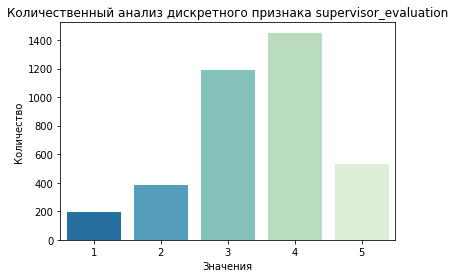

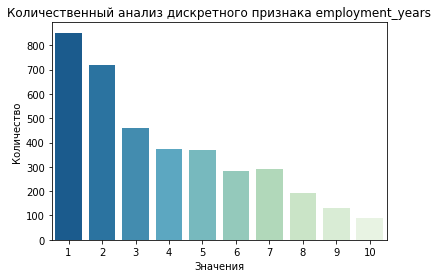

Статистический анализ показателя salary
--------------------------------------------------------------------------------------------------------------


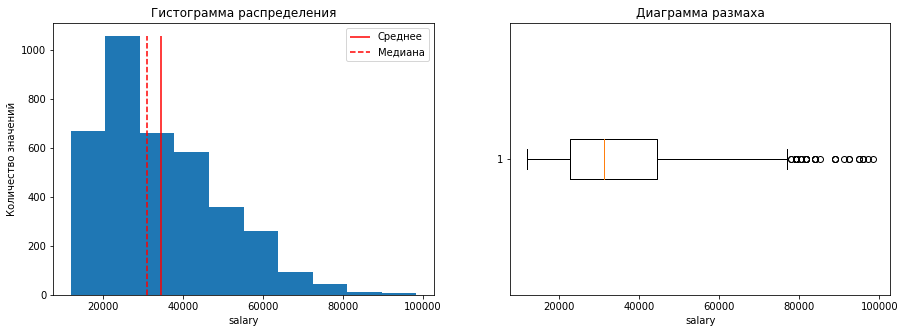

Статистический анализ показателя job_satisfaction_rate
--------------------------------------------------------------------------------------------------------------


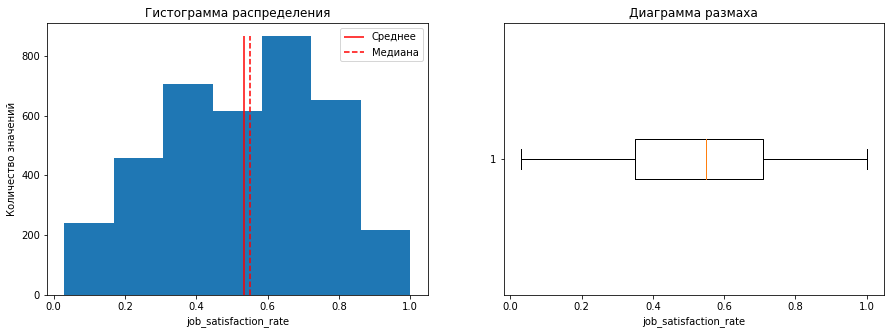

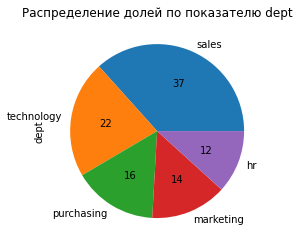

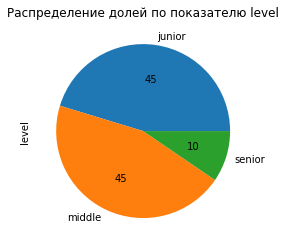

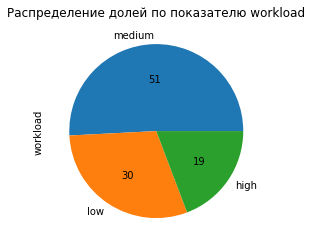

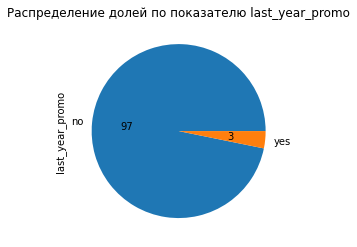

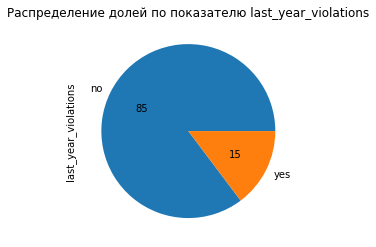

In [15]:
#отключение ошибок
warnings.filterwarnings('ignore')
#список дискретных признаков
contplots = [
    'supervisor_evaluation',
    'employment_years'
]
#список признаков с индивидуальными значениями кол-ва корзин для гистограмм
custom_bins = {
    'job_satisfaction_rate': 7
}
#печать графиков
stat_plots(train, custom_bins, contplots)

### Анализ корреляций

Произведем анализ корреляций для тренировочного датасета

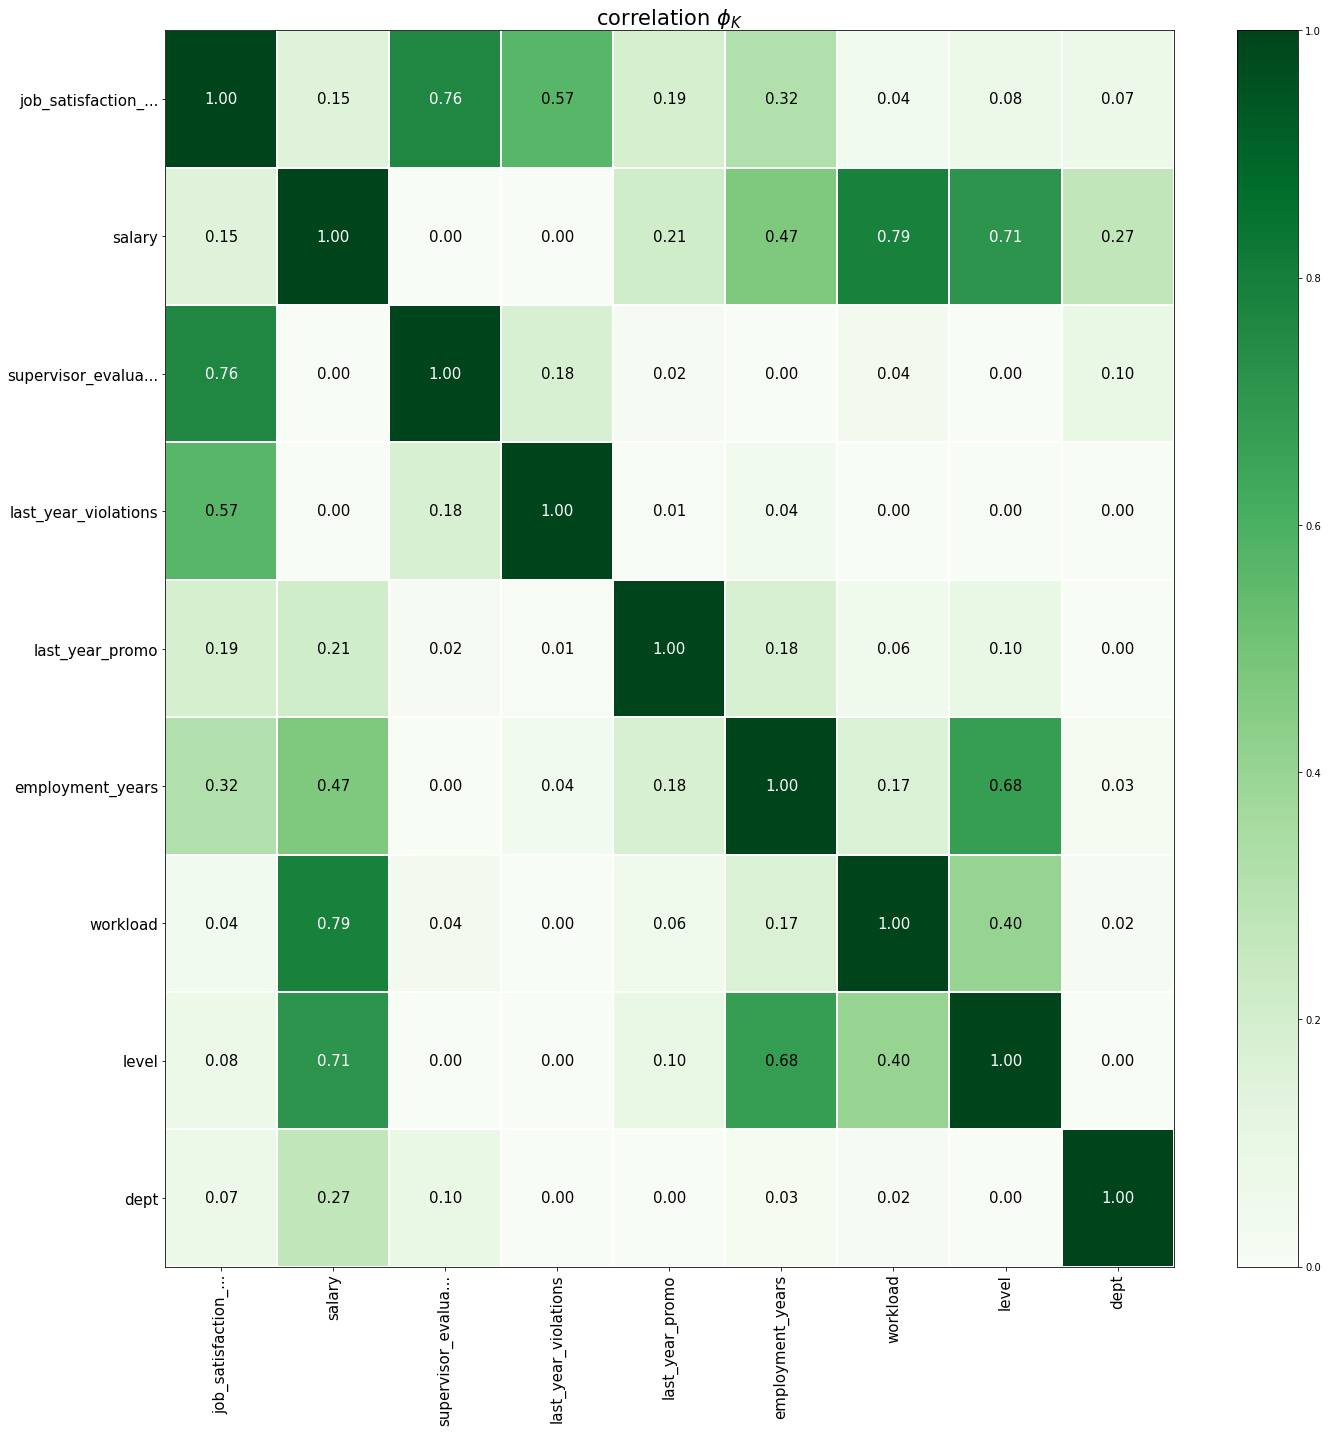

In [16]:
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(train, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

Произведем анализ корреляций для тестового датасета

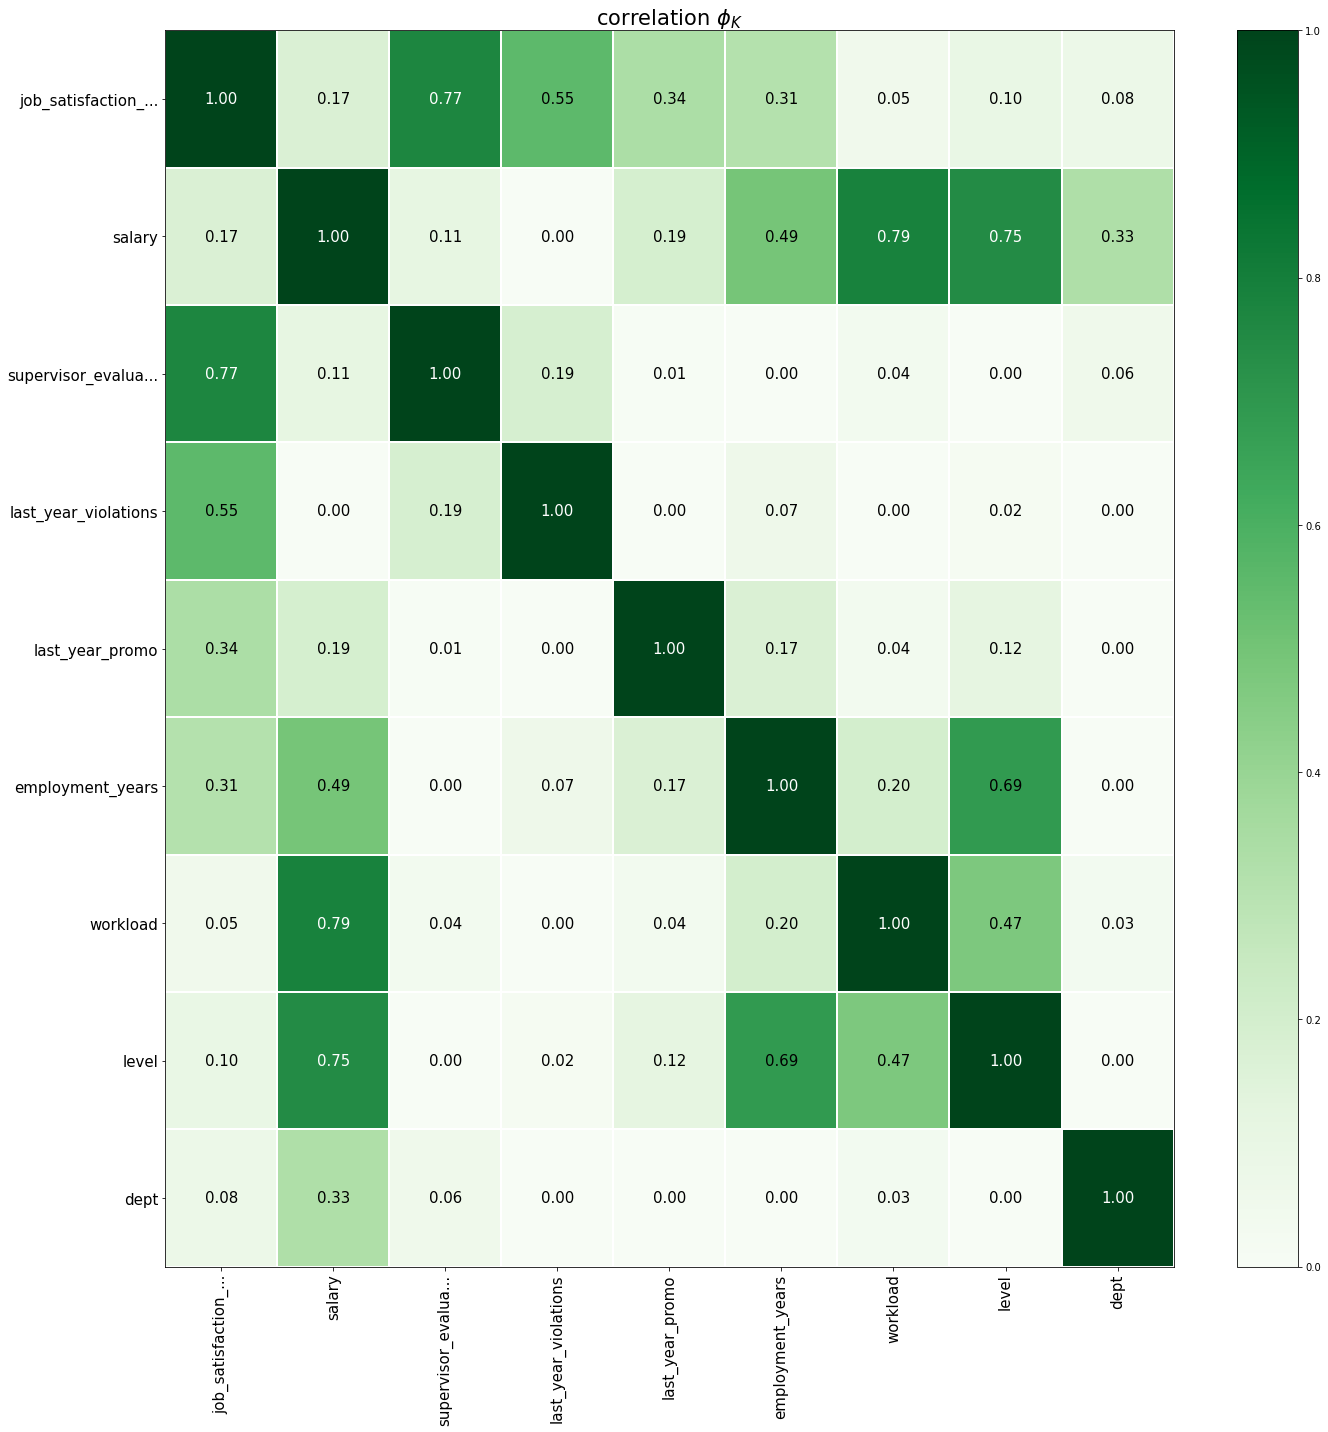

In [17]:
test = test_data.merge(test_target, on='id')

interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(test, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

### Промежуточный вывод

Тренировочный и тестовый наборы данных показывают одинаковую картину - можно утверждать, что эти выборки независимые.

Как мы видим на диаграммах распределения, все числовые признаки, включая целевой, имеют ненормальное распределение.

Есть выбросы в данных о зарплате и оценках, которые имеют естесственное происхождение.

Все категориальные признаки имеют дисбаланс классов, наиболее выраженный у следующих:
- level (уровень должности)
- last_year_promo (наличие повышения)
- last_year_violations (наличие штрафов)

Анализ корреляций обоих наборов данных также показывает одинаковую картину наличия взаимозависимых входных признаков при отсутствии мультиколлинеарности.

## Подготовка данных

### Подготовка выборок

In [18]:
X_train = train.drop(['job_satisfaction_rate'], axis=1)
y_train = np.array(train['job_satisfaction_rate'])
X_test = test_data
y_test = np.array(test_target['job_satisfaction_rate'])

Создадим списки колонок категориальных текстовых признаков для разных способов кодировки

### Пайплайн предобработки

Разметим колонки по типам для кодировки

In [19]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = X_train.columns[~X_train.columns.isin(ohe_columns + ord_columns)]
num_columns

Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')

Создадим пайплайн для шага предобработки OneHotEncoder

In [20]:
ohe_step = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))  
])

Создадим пайплайн для шага предобработки OrdinalEncoder

In [21]:
ord_step = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']],
        handle_unknown='use_encoded_value', unknown_value=-1))  
])

Создадим общий пайплайн для предобработки всех видов данных

In [22]:
preprocessor = ColumnTransformer([
    ('ohe', ohe_step, ohe_columns),
    ('ord', ord_step, ord_columns),
    ('num', MinMaxScaler(), num_columns),
], remainder='drop')

### Подбор гиперпараметров

Создадим пайплайн для подбора гиперпараметров

In [23]:
pipe_train =  Pipeline([
    ('preprocessor', preprocessor),
    ('models', 'passthrough')
])

Зададим набор моделей, их гиперпараметров и инструментов масштабирования, для полного пайплайна:

In [24]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }   
]

Создадим функцию для расчета sMAPE (symmetric mean absolute percentage error)

In [25]:
#функция рассчета метрики SMAPE
def get_smape(y_test, y_pred):
    numerator = abs(y_test - y_pred)
    denominator = (abs(y_test) + abs(y_pred)) / 2
    smape = sum(numerator / denominator) * 100 / len(y_test)
    return int(smape)

Зададим SMAPE как кастомную метрику для подбора гиперпараметров

In [26]:
smape_score = make_scorer(
    get_smape,
    greater_is_better=False
)

In [27]:
cv_test = RandomizedSearchCV(
    pipe_train,
    param_grid,
    n_jobs=-1,
    cv=5,
    n_iter=50,
    scoring=smape_score
)

In [28]:
warnings.filterwarnings('ignore')
cv_test.fit(X_train, y_train)

pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(cv_test.cv_results_)
result[
    ['rank_test_score', 'param_preprocessor__num', 'params']
].sort_values('rank_test_score').head(5)

,rank_test_score,param_preprocessor__num,params
37,1,passthrough,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 13, 'models__min_samples_leaf': 5, 'models__max_features': 9, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=88)}"
29,1,passthrough,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 3, 'models__max_features': 8, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=88)}"
43,3,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 12, 'models__max_features': 11, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=88)}"
36,4,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 11, 'models__max_features': 11, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=88)}"
9,4,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 11, 'models__min_samples_leaf': 6, 'models__max_features': 10, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=88)}"


## Проверка модели на тестовых данных

Произведем расчет метрики sMAPE для случайного прогноза

In [29]:
dr = DummyRegressor(constant=0.5, strategy='median')
dr.fit(X_train, y_train)
y_pred_dummy = dr.predict(X_test)
print(f'Значение метрики sMAPE у DummyRegressor: {get_smape(y_test, y_pred_dummy)}')

Значение метрики sMAPE у DummyRegressor: 37


In [30]:
best_suite = cv_test.best_estimator_
best_suite.fit(X_train, y_train)
y_pred = best_suite.predict(X_test)

In [31]:
print(f'Значение метрики sMAPE у лучшей модели: {get_smape(y_test, y_pred)}')
print(f'Лучшая модель и ее параметры: {best_suite.named_steps["models"]}')

Значение метрики sMAPE у лучшей модели: 14
Лучшая модель и ее параметры: DecisionTreeRegressor(max_depth=13, max_features=8, min_samples_leaf=3,
                      min_samples_split=5, random_state=88)


## Результат

По результатам подбора параметров наилучшее значение метрики sMAPE = 13 продемонстрировала следующая модель:\
DecisionTreeRegressor(max_depth=13, max_features=9, min_samples_leaf=3, min_samples_split=7, random_state=88)

## Задача 2

### Загрузка и предобработка данных

In [32]:
train2 = pd.read_csv('/datasets/train_quit.csv', index_col='id')
test_data2 = pd.read_csv('/datasets/test_features.csv')
test_target2 = pd.read_csv('/datasets/test_target_quit.csv')

In [33]:
data_report(train2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
-------------------------------------------

In [34]:
train2 = train2.drop_duplicates()

In [35]:
train2['level'] = train2['level'].replace({'sinior': 'senior'})

In [36]:
data_report(test_data2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 2
------------------------------------------------------------------------------------------
Перечень столбцов с пустыми и нулевыми значениями:

In [37]:
test_data2['level'] = test_data2['level'].replace({'sinior': 'senior'})
test_data2['dept'] = test_data2['dept'].replace({' ': np.nan})
test_data2['workload'] = test_data2['workload'].replace({' ': np.nan})

In [38]:
data_report(test_target2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
Уникальные значения в тестовых полях
quit: ['yes' 'no']
------------------------------------------------------------------------------------------


Приведем тестовые детасеты к единообразию по индексам:

In [39]:
test2 = test_data2.merge(test_target2, on='id').sort_values(by='id').set_index('id')
test_data2 = test2.drop('quit', axis=1)
test_target2 = test2['quit'].to_frame()

### Исследовательский анализ

#### Анализ распределений

Построим графики при помощи ранее определенной функции

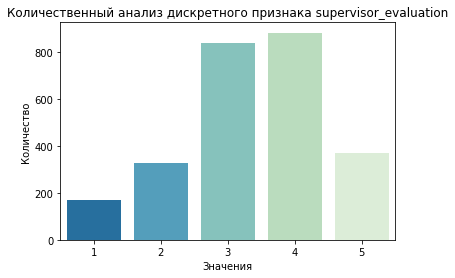

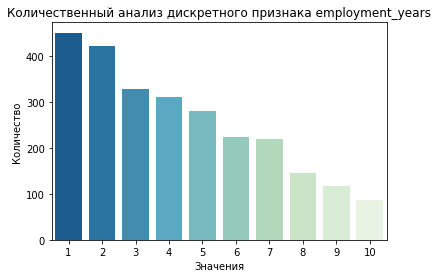

Статистический анализ показателя salary
--------------------------------------------------------------------------------------------------------------


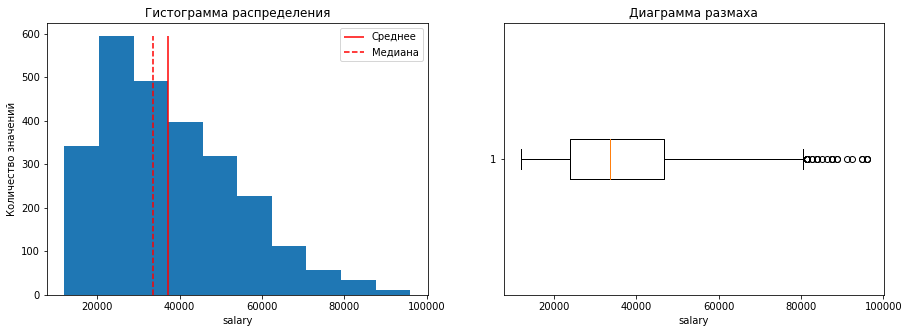

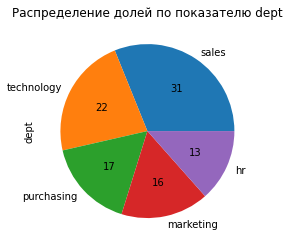

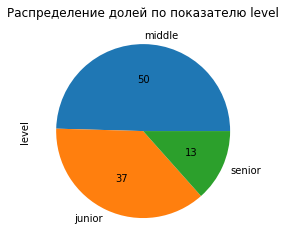

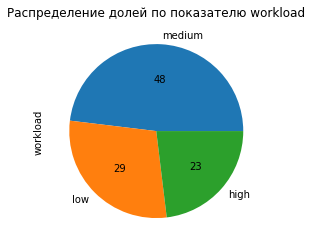

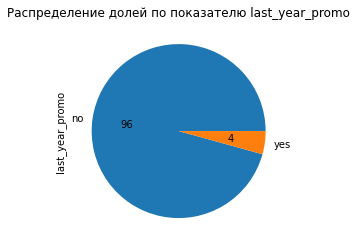

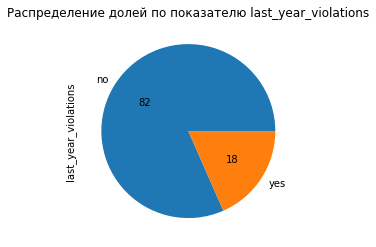

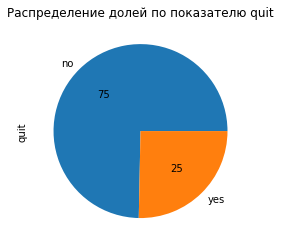

In [40]:
#отключение ошибок
warnings.filterwarnings('ignore')
#список дискретных признаков
contplots = [
    'supervisor_evaluation',
    'employment_years'
]
#список признаков с индивидуальными значениями кол-ва корзин для гистограмм
custom_bins = {
    'job_satisfaction_rate': 5
}
#печать графиков
stat_plots(train2, custom_bins, contplots)

#### Анализ корреляций

Произведем анализ корреляций для тренировочного датасета

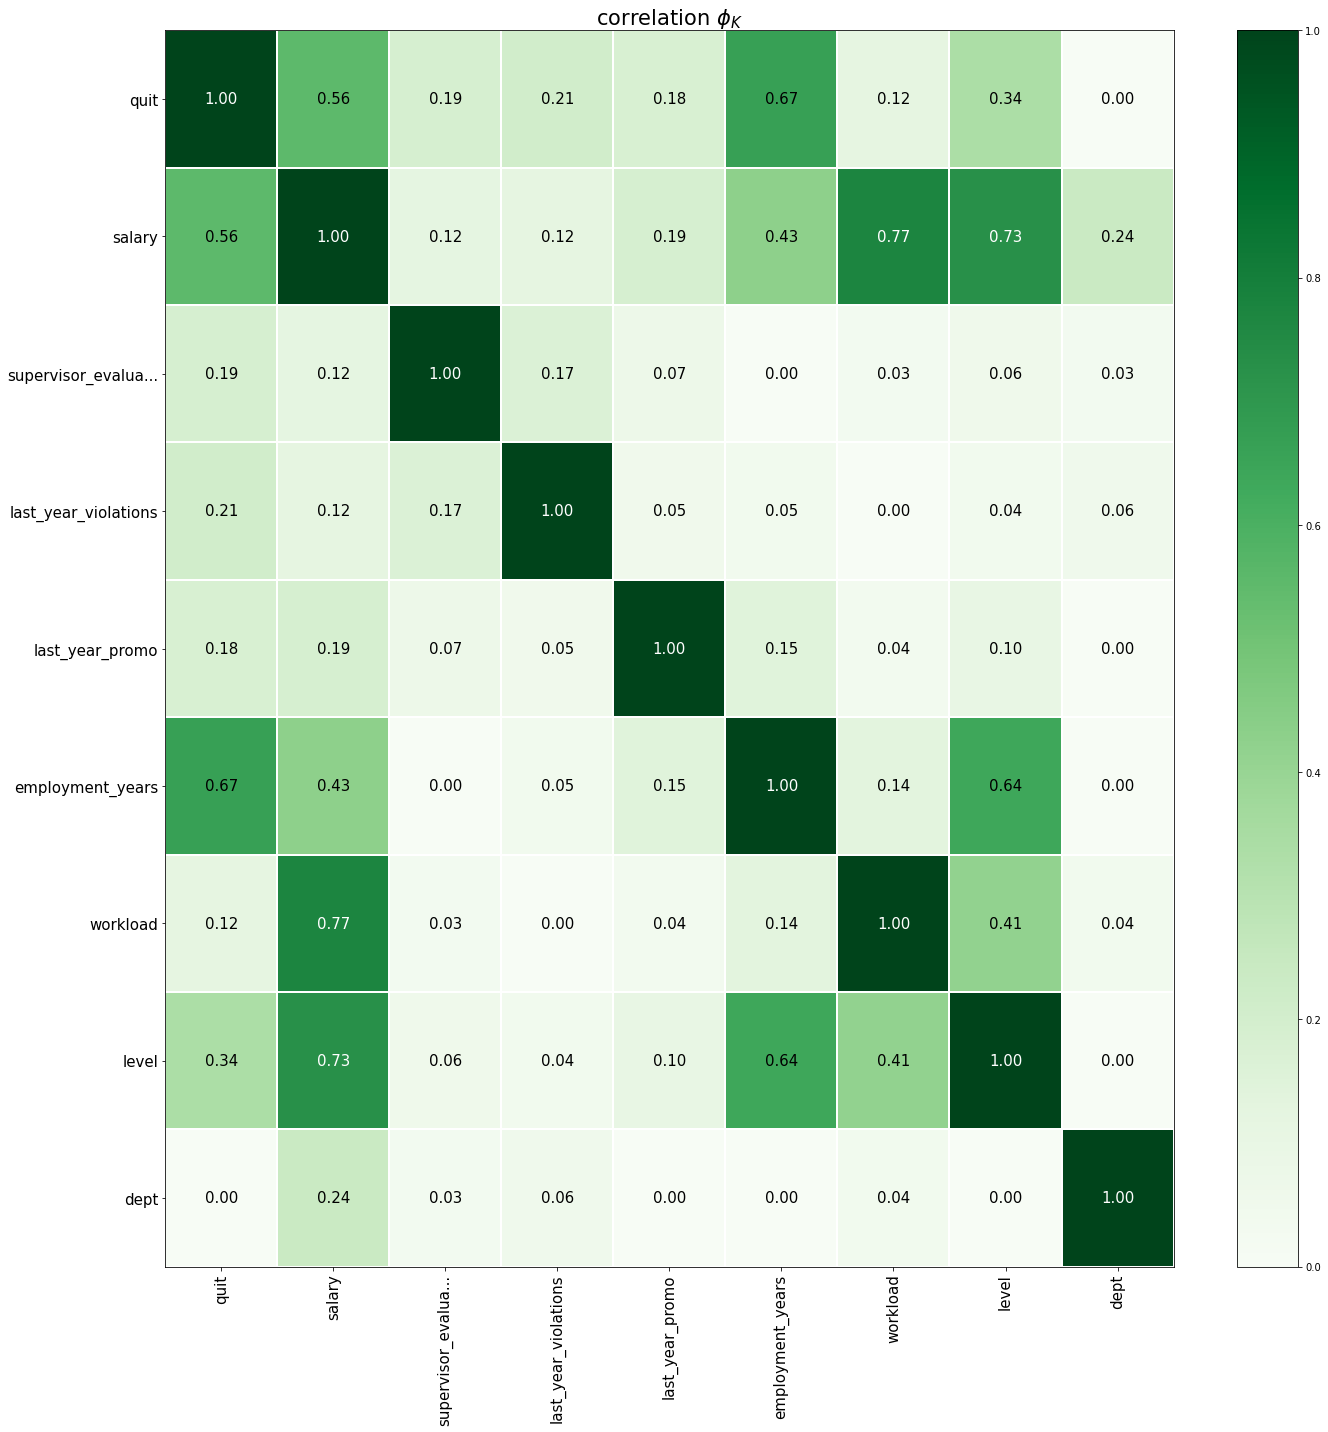

In [41]:
interval_cols = ['salary']
phik_overview = phik_matrix(train2, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

Произведем анализ корреляций для тестового датасета

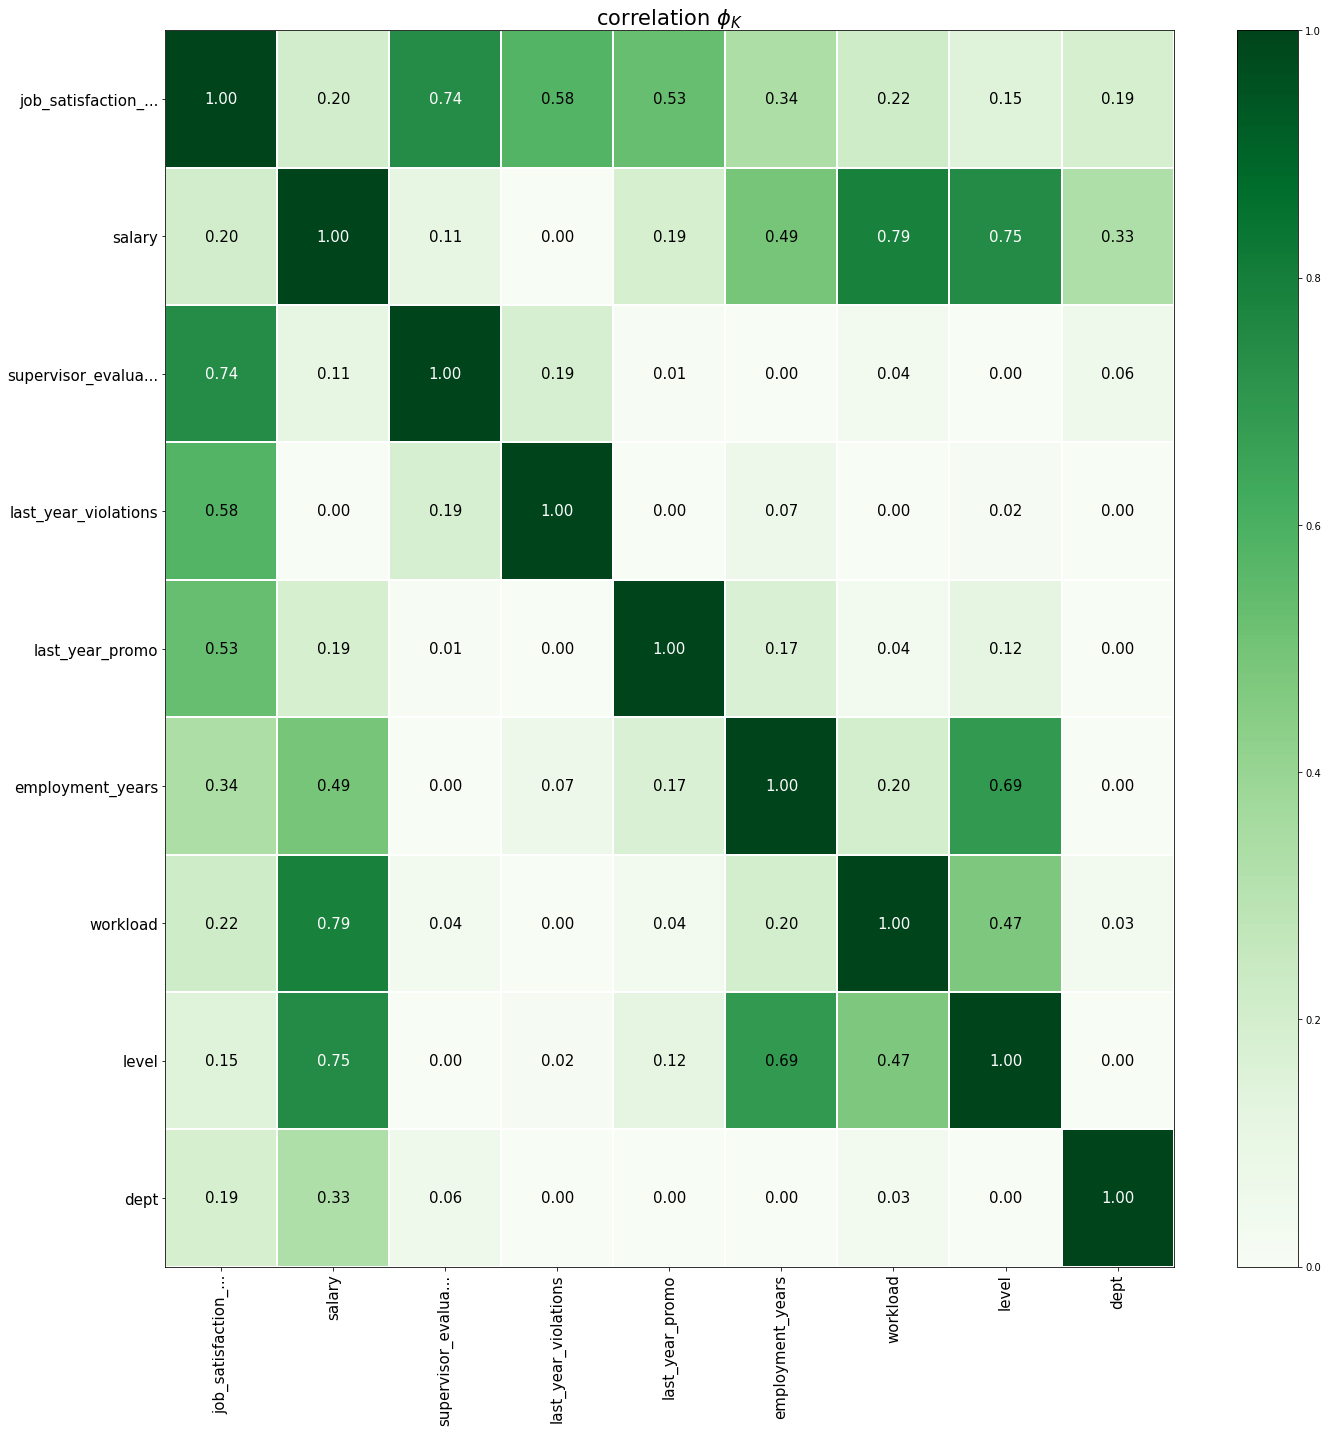

In [42]:
test2 = test_data2.merge(test_target, on='id')

interval_cols = ['salary']
phik_overview = phik_matrix(test, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

#### Портрет уволившегося работника

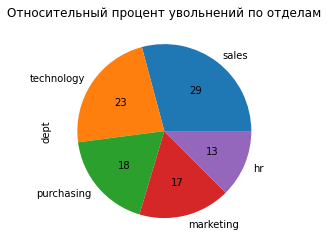

In [43]:
quit = train2[train2['quit'] == 'yes']['dept'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по отделам')
plt.show()

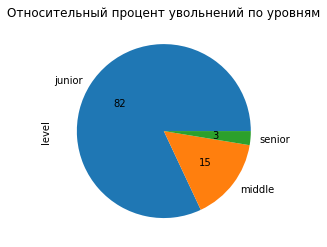

In [44]:
quit = train2[train2['quit'] == 'yes']['level'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по уровням')
plt.show()

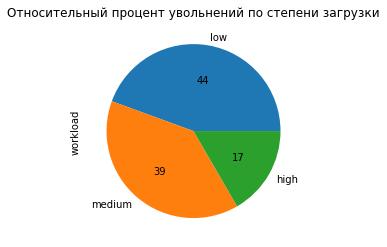

In [45]:
quit = train2[train2['quit'] == 'yes']['workload'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по степени загрузки')
plt.show()

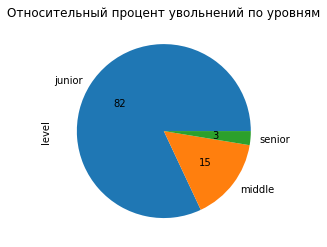

In [46]:
quit = train2[train2['quit'] == 'yes']['level'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по уровням')
plt.show()

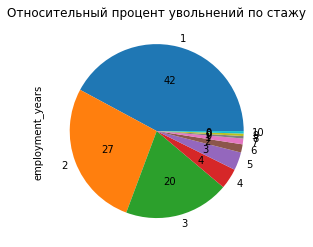

In [47]:
quit = train2[train2['quit'] == 'yes']['employment_years'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по стажу')
plt.show()

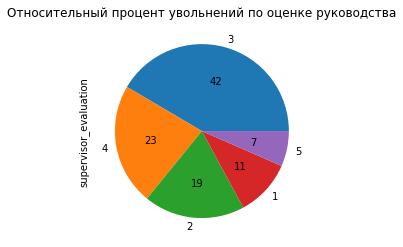

In [48]:
quit = train2[train2['quit'] == 'yes']['supervisor_evaluation'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по оценке руководства')
plt.show()

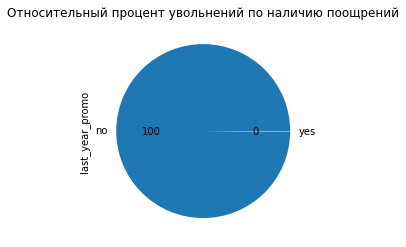

In [49]:
quit = train2[train2['quit'] == 'yes']['last_year_promo'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по наличию поощрений')
plt.show()

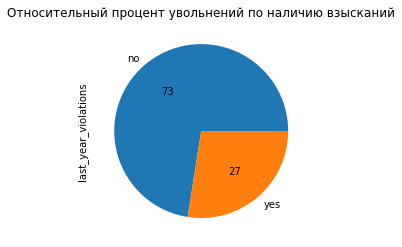

In [50]:
quit = train2[train2['quit'] == 'yes']['last_year_violations'].value_counts(normalize=True)
quit.plot(kind='pie', autopct='%.0f')
plt.title('Относительный процент увольнений по наличию взысканий')
plt.show()

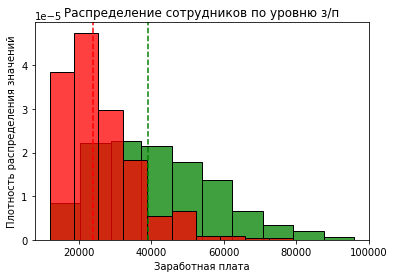

In [51]:
stay = train2[train2['quit'] == 'no']['salary']
quit = train2[train2['quit'] == 'yes']['salary']
sns.histplot(data=stay, color='green', bins=10, stat='density', common_norm=False)
sns.histplot(data=quit, color='red', bins=10, stat='density', common_norm=False)
plt.axvline(x=stay.median(), color='green', linestyle='--')
plt.axvline(x=quit.median(), color='red', linestyle='--')
plt.title('Распределение сотрудников по уровню з/п')
plt.ylabel('Плотность распределения значений')
plt.xlabel('Заработная плата')
plt.show()

In [52]:
print(f'Средняя зарплата уволившихся сотрудников ниже на {(stay.mean() - quit.mean()).round(0)} рублей')

Средняя зарплата уволившихся сотрудников ниже на 15184.0 рублей


**Портрет уволившегося сотрудника**\
Как видно на диаграммах, увольняются из компании в основном новые сотрудники с низкой квалификацией, низкой загрузкой, низкой зарплатой и нейтральными оценками руководителей, вне зависимости от отдела. 

#### Анализ дополнительного признака 

Добавим в тестовый датасет целевые признаки обеих задач

In [53]:
test2_added = test_data2.merge(test_target2, on='id').merge(test_target, on='id')

In [54]:
test2_added.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,no,0.80
100480,marketing,junior,low,4,no,no,4,16800,no,0.84
100503,purchasing,middle,high,5,no,no,4,55200,no,0.79
100610,sales,middle,medium,5,no,no,4,43200,no,0.75
100692,sales,middle,high,6,no,no,4,48000,no,0.69


Построим сравнительную диаграмму распределения уровня удовлетворенности работой для работающих и уволившихся сотрудников.

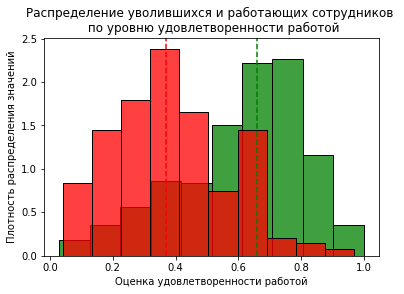

In [55]:
stay = test2_added[test2_added['quit'] == 'no']['job_satisfaction_rate']
quit = test2_added[test2_added['quit'] == 'yes']['job_satisfaction_rate']
sns.histplot(data=stay, color='green', bins=10, stat='density', common_norm=False)
sns.histplot(data=quit, color='red', bins=10, stat='density', common_norm=False)
plt.axvline(x=stay.median(), color='green', linestyle='--')
plt.axvline(x=quit.median(), color='red', linestyle='--')
plt.title('Распределение уволившихся и работающих сотрудников \n по уровню удовлетворенности работой')
plt.ylabel('Плотность распределения значений')
plt.xlabel('Оценка удовлетворенности работой')
plt.show()

#### Промежуточный вывод

**Анализ данных**\
Тренировочный и тестовый наборы данных показывают одинаковую картину - можно утверждать, что эти выборки независимые.

Как мы видим на диаграммах распределения, все числовые признаки, включая целевой, имеют ненормальное распределение.

Есть выбросы в данных о зарплате и оценках, которые имеют естесственное происхождение.

Все категориальные признаки имеют дисбаланс классов, наиболее выраженный у следующих:
- level (уровень должности)
- last_year_promo (наличие повышения)
- last_year_violations (наличие штрафов)

Анализ корреляций обоих наборов данных также показывает одинаковую картину наличия взаимозависимых входных признаков при отсутствии мультиколлинеарности.

**Портрет уволившегося сотрудника**\
Как видно на диаграммах, увольняются из компании в основном новые сотрудники с низкой квалификацией, низкой загрузкой, низкой зарплатой и нейтральными оценками руководителей, вне зависимости от отдела. 

**Уровень удовлетворенности работой**\
Среди уволившихся сотрудников уровень удовлетворенности работой значительно ниже.\
Это значит, что мы можем использовать эти данные как входной признак для прогнозирования возможности увольнения сотрудников.

In [56]:
train.reset_index()
train.sort_values(by='id').head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600,0.60
101057,sales,junior,low,1,no,yes,4,19200,0.45
101074,sales,junior,medium,2,no,no,2,20400,0.36


In [57]:
train2.reset_index()
train2.sort_values(by='id').head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100858,sales,junior,medium,2,no,no,4,25200,yes


<div class="alert alert-info">
<h2> Комментарий студента 3<a class="tocSkip"> </h2>
    Выполнено.
</div>

### Расчет прогнозов оценки удовлетворенности

Выполним предсказания удовлетворенности работой для тренировочного датасета:

In [58]:
data2 = train2.drop('quit', axis=1)
train2['job_satisfaction_rate'] = best_suite.predict(data2)
train2.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.589778
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.359412
910140,marketing,junior,medium,2,no,no,5,25200,no,0.811111


Выполним предсказания job_satisfaction_rate для тестового набора признаков

In [59]:
test_data2['job_satisfaction_rate'] = best_suite.predict(test_data2)
test_data2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.838125
100480,marketing,junior,low,4,no,no,4,16800,0.852000
100503,purchasing,middle,high,5,no,no,4,55200,0.788750
100610,sales,middle,medium,5,no,no,4,43200,0.828077
100692,sales,middle,high,6,no,no,4,48000,0.702500


### Подготовка выборок

Инициализируем выборки для обучения с кросс-валидацией и тестирования:

In [60]:
X_train = train2.drop(['quit'], axis=1)
y_train = np.array(train2['quit'])
X_test = test_data2
y_test = np.array(test_target2['quit'])

Закодируем целевой признак и выясним принцип кодировки:

In [61]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train[0:5]

array([0, 0, 0, 1, 0])

### Подбор гиперпараметров

Для подбора гиперпараметров будем использовать ранее созданные:
- пайплайн предобработки данных **preprocessor**
- пайплайн подбора гиперпараметров **pipe_train**

Зададим набор моделей, их гиперпараметров и инструментов масштабирования, для задачи классификации:

In [62]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'models__max_depth': range(2, 15),
#        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 25),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel = 'poly', probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

In [63]:
#инициализация инструмента подбора
model_lookup = RandomizedSearchCV(
    pipe_train,
    param_grid,
    n_jobs=-1,
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    random_state=RANDOM_STATE
)

In [64]:
model_lookup.fit(X_train, y_train)

pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(model_lookup.cv_results_)
result[
    ['rank_test_score', 'param_preprocessor__num', 'params']
].sort_values('rank_test_score').head(5)

,rank_test_score,param_preprocessor__num,params
29,1,passthrough,"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 8, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=88)}"
16,2,MinMaxScaler(),"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 9, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=88)}"
38,2,StandardScaler(),"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 9, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=88)}"
2,4,MinMaxScaler(),"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 11, 'models__min_samples_leaf': 10, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=88)}"
43,5,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__C': 10, 'models': LogisticRegression(penalty='l1', random_state=88, solver='liblinear')}"


### Тестирование лучшей модели

Произведем расчет метрики sMAPE для случайного прогноза

In [65]:
dc = DummyClassifier(random_state=RANDOM_STATE, strategy='most_frequent')
dc.fit(X_train, y_train)
dummy_probas = dc.predict_proba(X_test)[:,1]
roc_auc_dummy = roc_auc_score(y_test, dummy_probas)
print(f'Значение ROC-AUC у DummyClassifier: {roc_auc_dummy.round(2)}')

Значение ROC-AUC у DummyClassifier: 0.5


Произведем подбор гиперпараметров при помощи пайплайна:

In [66]:
best_suite = model_lookup.best_estimator_
best_suite.fit(X_train, y_train)
print(f'Лучшая модель и ее параметры: {best_suite.named_steps["models"]}')

Лучшая модель и ее параметры: DecisionTreeClassifier(max_depth=5, min_samples_leaf=8, min_samples_split=5,
                       random_state=88)


Зафиксируем лучшую модель константой для дальнейшего тестирования

In [67]:
best_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=4, random_state=88)

Обучим лучшую модель и проверим ее на тестовом датасете

In [68]:
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.fit_transform(X_test)
best_model.fit(X_train_p, y_train)
probas = best_model.predict_proba(X_test_p)[:,1]
roc_auc = roc_auc_score(y_test, probas)
print(f'Значение ROC-AUC на тестовом датасете = {roc_auc.round(3)}')

Значение ROC-AUC на тестовом датасете = 0.911


### Результат

Значение метрики ROC-AUC у лучшей модели **0.911**, что соответствует требуемым критериям качества.\
Лучшая модель и ее параметры: **DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=4, random_state=88)**

### Подбор лучших признаков

Выполним подбор лучших признаков методом SelectKBest на основании двух тестов:
- f_classif (проверка уровня линейной зависимости)
- mutual_info_classif (проверка взаимной зависимости признаков)

In [69]:
param_kbest = [
    # словарь для теста f_classif
    {
        'models': [SelectKBest(f_classif)],
        'models__k': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для теста mutual_info_classif
    {
        'models': [SelectKBest(mutual_info_classif)],
        'models__k': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }   
]

In [70]:
#инициализация инструмента подбора
kbest_lookup = RandomizedSearchCV(
    pipe_train,
    param_kbest,
    cv=5,
    n_iter=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE
)

In [71]:
kbest_lookup.fit(X_train, y_train)

pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(kbest_lookup.cv_results_)
result[
    ['rank_test_score', 'param_preprocessor__num', 'params']
].sort_values('rank_test_score').head(5)

,rank_test_score,param_preprocessor__num,params
0,1,passthrough,"{'preprocessor__num': 'passthrough', 'models__k': 13, 'models': SelectKBest(score_func=<function mutual_info_classif at 0x7f8d3d473670>)}"
1,1,MinMaxScaler(),"{'preprocessor__num': MinMaxScaler(), 'models__k': 2, 'models': SelectKBest(score_func=<function mutual_info_classif at 0x7f8d3d473670>)}"
2,1,passthrough,"{'preprocessor__num': 'passthrough', 'models__k': 12, 'models': SelectKBest()}"
3,1,MinMaxScaler(),"{'preprocessor__num': MinMaxScaler(), 'models__k': 10, 'models': SelectKBest(score_func=<function mutual_info_classif at 0x7f8d3d473670>)}"
4,1,RobustScaler(),"{'preprocessor__num': RobustScaler(), 'models__k': 2, 'models': SelectKBest()}"


In [72]:
X_train_pp = preprocessor.fit_transform(X_train)
X_train_pp = pd.DataFrame(X_train_pp, columns=range(0, X_train_pp.shape[1]))

selector = SelectKBest(f_classif, k=7) #значение 7 показывает после GridSearcCV, но он долго считается, поэтому я его заменил
X_kbest = selector.fit_transform(X_train_pp, y_train)

kbest_columns = X_train_pp.columns[selector.get_support(indices=True)].to_list()
print(f'Лучший набор колонок предобработанного тренировочного датасета (номера): {kbest_columns}')

Лучший набор колонок предобработанного тренировочного датасета (номера): [4, 5, 6, 7, 8, 9, 10]


## Итоговый вывод

В этом проекте мы анализировали данные о характеристиками сотрудников компании «Работа с заботой».\
Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.\
Задачей проекта являлось разработать подобрать и обучить модели, которые с заданным уровнем качества будут предсказывать уровень удовлетворенности сотрудников и вероятность их увольнения из компании.

В качестве исходных данных в нашем распоряжении были готовые датасеты для каждой из двух задач:
- Тренировочный датасет с данными о характеристиках сотрудников и целевым признаком
- Тестовый датасет с характеристиках сотрудников
- Тестовый датасет с целевым признаком

В процессе предобработки данных были выполнены следующие операции:
- Устранена одна опечатка, не вызывавшая дублирования данных.
- Заменены пробелы в данных на пустые значения, для дальнейшей обработки средствами пайплайна.
- Приведены в соответствие индексы таблиц тестовых датасетов.

**Задача 1**

В этой задаче мы решали задачу регрессии для предсказания непрерывного целевого признака job_satisfaction_rate при помощи следующих моделей:
- LinearRegression()
- DecisionTreeRegressor()

Для выбора модели были построены пайплайны предобработки данных и подбора гиперпараметров.\
Для кодировки категориальных данных были задействованы кодировщики **One Hot Encoder** и **Ordinal Encoder**, целевой признак мы закодировали с помощью **Label Encoder**.\
Для оценки качества модели мы использовали кастомную метрику sMAPE (symmetric mean absolute percentage error), с критерием успеха <= 15.\
Для поиска лучшей модели  мы использовали инструмент подбора гиперпараметров **Randomized Search** с кросс-валидацией на тренировочном датасете.

По результатам подбора параметров наилучшее значение метрики **sMAPE = 13** продемонстрировала следующая модель:\
**DecisionTreeRegressor(max_depth=13, max_features=9, min_samples_leaf=3, min_samples_split=7, random_state=88)**

**Задача 2**

Для выполнения этой задачи был произведен дополнительный анализ зависимости склонности сотрудников к увольнению от уровня удовлетворенности сотрудника работой, который показал наличие заметной зависимости между этими признаками.\
На основании результатов этого анализа, целевой признак job_satisfaction_rate из первой задачи был добавлен как входной признак путем выполнения предсказаний с помощью лучшей модели, обученной в первой задаче.\

С этим набором признаков мы решали задачу классификации для предсказания бинарного текстового целевого признака quit при помощи следующих моделей:
- LogisticRegression()
- DecisionTreeClassifier()
- SVC()
- KNeighborsClassifier()

Для выбора моделей использовались пайплайны предобработки данных и подбора гиперпараметров из первой модели.\
Целевой признак мы дополнительно закодировали с помощью **Label Encoder**.\
Для оценки качества модели мы использовали метрику ROC-AUC, с критерием успеха >= 0.91.\
Для поиска лучшей модели  мы использовали инструмент подбора гиперпараметров **Randomized Search** с кросс-валидацией на тренировочном датасете.\

По результатам подбора параметров было зарегистрировано наилучшее значение метрики ROC-AUC **0.911** \
Лучшая модель и ее параметры: **DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, min_samples_split=4, random_state=88)**

**Рекомендации бизнесу по результатам анализа портрета уволившегося сотрудника:**\
Для предотвращения оттока сотрудников следует проводить больше работы в новыми сотрудниками компании с низким уровнем квалификации и минимальной зарплатой, например:
- Увеличивать их рабочую нагрузку
- Внимательно и справедливо оценивать результаты их работы
- Соблюдать баланс поощрений и наказаний
- Предоставлять им ясные возможности для карьерного роста